In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# from teamName.py
#!/usr/bin/envblah python

import numpy as np
import pandas as pd
# from teamName import getMyPosition as getPosition

# Algorithm testing file. 
# Quantitative judging will be determined from output of this program.
# Judging will use unseeen, future price data from the same universe.

nInst = 0
nt = 0

# Commission rate.
commRate = 0.0050

# Dollar position limit (maximum absolute dollar value of any individual stock position).
dlrPosLimit = 10000

def loadPrices(fn):
    global nt, nInst
    df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
    nt, nInst = df.values.shape
    return (df.values).T

pricesFile="./prices250.txt"
prcAll = loadPrices(pricesFile)
print ("Loaded %d instruments for %d days" % (nInst, nt))

def calcPL(prcHist):
    cash = 0
    curPos = np.zeros(nInst)
    totDVolume = 0
    totDVolume0 = 0
    totDVolume1 = 0
    frac0 = 0.
    frac1 = 0.
    value = 0
    valueData = []  # for plotting results
    todayPLL = []
    (_,nt) = prcHist.shape
    for t in range(1, 251):  # changed this to (0, 251) from (201, 251)
        prcHistSoFar = prcHist[:,:t]
        newPosOrig = getPosition(prcHistSoFar)
        curPrices = prcHistSoFar[:,-1] 
        posLimits = np.array([int(x) for x in dlrPosLimit / curPrices])
        newPos = np.array([int(p) for p in np.clip(newPosOrig, -posLimits, posLimits)])
        deltaPos = newPos - curPos
        dvolumes = curPrices * np.abs(deltaPos)
        dvolume0 = np.sum(dvolumes[:50])
        dvolume1 = np.sum(dvolumes[50:])
        dvolume = np.sum(dvolumes)
        totDVolume += dvolume
        totDVolume0 += dvolume0
        totDVolume1 += dvolume1
        comm = dvolume * commRate
        cash -= curPrices.dot(deltaPos) + comm
        curPos = np.array(newPos)
        posValue = curPos.dot(curPrices)
        todayPL = cash + posValue - value
        todayPLL.append(todayPL)
        value = cash + posValue
        valueData.append(value)  # for plotting results
        ret = 0.0
        if (totDVolume > 0):
            ret = value / totDVolume
            frac0 = totDVolume0 / totDVolume
            frac1 = totDVolume1 / totDVolume
        # old print
        # print ("Day %d value: %.2lf todayPL: $%.2lf $-traded: %.0lf return: %.5lf frac0: %.4lf frac1: %.4lf" % (t,value, todayPL, totDVolume, ret, frac0, frac1))
#         print ("Day %3d value: %9.2lf todayPL: $%8.2lf $-traded: %7.0lf return: %8.5lf frac0: %6.4lf frac1: %6.4lf" % (t,value, todayPL, totDVolume, ret, frac0, frac1))
    pll = np.array(todayPLL)
    (plmu,plstd) = (np.mean(pll), np.std(pll))
    annSharpe = 0.0
    if (plstd > 0):
        annSharpe = 16 * plmu / plstd
    
    plt.figure(figsize=(10, 8))
    sns.lineplot(x=range(1, 251), y=valueData)
    
    return (plmu, ret, annSharpe, totDVolume)

Loaded 100 instruments for 250 days


In [2]:
# prices
prcAll

array([[18.25, 18.22, 18.28, ..., 19.37, 19.22, 19.18],
       [ 7.34,  7.35,  7.34, ...,  7.41,  7.39,  7.39],
       [17.95, 18.01, 18.04, ..., 19.08, 19.11, 19.18],
       ...,
       [ 3.33,  3.31,  3.36, ...,  3.36,  3.37,  3.34],
       [ 2.64,  2.63,  2.67, ...,  2.51,  2.59,  2.5 ],
       [19.19, 19.75, 20.07, ..., 18.85, 19.16, 18.86]])

In [3]:
prcAll[0]  # prices for instrument 0

array([18.25, 18.22, 18.28, 18.07, 18.2 , 18.15, 18.24, 18.39, 18.34,
       18.41, 18.36, 18.43, 18.62, 18.74, 18.35, 18.42, 18.32, 18.16,
       17.89, 18.12, 18.15, 18.12, 18.08, 18.46, 18.31, 18.36, 18.36,
       18.19, 18.1 , 18.21, 18.26, 18.42, 18.61, 18.69, 18.65, 18.58,
       18.43, 18.22, 18.14, 18.51, 18.63, 18.56, 18.52, 18.28, 18.33,
       18.38, 18.45, 18.33, 18.57, 18.4 , 18.45, 18.43, 18.3 , 18.36,
       18.34, 18.4 , 18.39, 18.37, 18.23, 18.17, 18.29, 18.26, 18.02,
       18.04, 18.02, 18.15, 18.09, 18.13, 18.16, 18.15, 18.12, 18.07,
       18.08, 18.15, 18.07, 18.32, 18.35, 18.37, 18.37, 18.71, 18.59,
       18.56, 18.4 , 18.65, 18.67, 18.64, 18.73, 18.8 , 19.02, 18.94,
       18.8 , 18.59, 18.59, 18.59, 18.62, 18.64, 18.86, 19.08, 19.21,
       19.62, 19.71, 19.61, 19.53, 19.66, 19.71, 19.78, 19.83, 19.81,
       19.87, 19.85, 20.04, 19.97, 20.12, 19.85, 19.76, 19.92, 19.98,
       19.97, 19.9 , 19.87, 19.88, 19.9 , 19.93, 19.9 , 19.72, 19.92,
       19.92, 19.86,

In [4]:
prcAll[0][0]

18.25

In [5]:
prices = prcAll

# Define strategy here

In [4]:
# TEMPLATE
nInst=100
currentPos = np.zeros(nInst)

# Dummy algorithm to demonstrate function format.
def getMyPosition (prcSoFar):
    global currentPos
    # (nins,nt) = prcSoFar.shape
    # rpos = np.array([int(x) for x in 1000 * np.random.randn(nins)])
    # currentPos += rpos
    # The algorithm must return a vector of integers, indicating the position of each stock.
    # Position = number of shares, and can be positve or negative depending on long/short position.
    return currentPos

In [11]:
# Baseline? Buy and Hold strategy, buys max position for all 100 instruments and sells at the end of the trading period (250 days)
# sells at the end of the trading period

posLimit = 10000

currentPos = np.zeros(nInst) 
day = 1

def getMyPosition(prcSoFar):
    global day
    global currentPos
    
#     print(prcSoFar)
#     print([price[0] for price in prcSoFar])
#     print(prcSoFar[:, -1])
    
    newPos = None
    if day == 1:  # buy
        print("Buying")
        newPos = posLimit // prcSoFar[:, -1]  # [posLimit // price[0] for price in prcSoFar]
    if day == 250:  # selling at end of day does affect results
        print("Selling")
        newPos = np.zeros(nInst)
    if newPos is not None:
        print(f"Transaction cost ${round(transactionCost(prcSoFar, currentPos, newPos), 2)}")
        currentPos = newPos
    day += 1
    return currentPos

In [6]:
def transactionCost(prcSoFar, currentPos, newPos):
    """
    Returns transaction cost for new position.

        transaction cost = 0.0050 * totalDollarVolumeTraded

    from eval.py
    """
    # Commission rate
    commRate = 0.0050
    currentPrices = prcSoFar[:,-1] 
    deltaPos = newPos - currentPos
    dvolumes = currentPrices * np.abs(deltaPos)
    dvolume0 = np.sum(dvolumes[:50])
    dvolume1 = np.sum(dvolumes[50:])
    dvolume = np.sum(dvolumes)
    return dvolume * commRate

Buying
Transaction cost $4995.24
Selling
Transaction cost $4902.01
=====
mean(PL): 40
return: 0.00242
annSharpe(PL): 0.14 
totDvolume: 4080282 


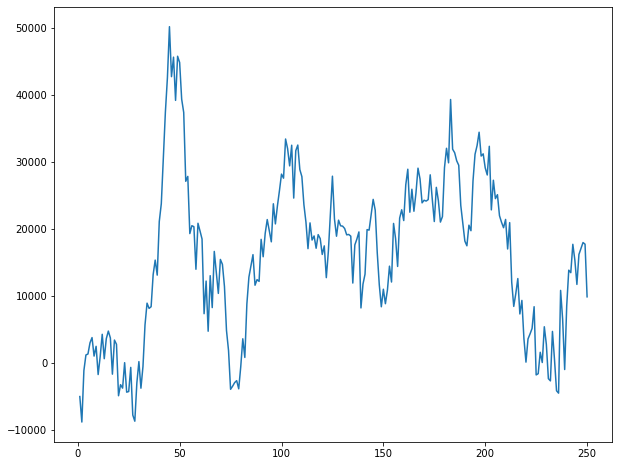

In [12]:
# Run calcPL here from eval.py
getPosition = getMyPosition

# Output
(meanpl, ret, sharpe, dvol) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)


===> sell 1109.0 @ 9.6


===> buy 1082.0 @ 9.24


===> sell 1082.0 @ 9.58


===> buy 1067.0 @ 9.37


===> sell 1067.0 @ 9.52


===> buy 1061.0 @ 9.42


===> sell 1061.0 @ 9.63


===> buy 1070.0 @ 9.34


===> sell 1070.0 @ 9.54


===> buy 1142.0 @ 8.75


===> sell 1142.0 @ 10.04


===> buy 1084.0 @ 9.22


===> sell 1084.0 @ 9.6


===> buy 1081.0 @ 9.25


===> sell 1081.0 @ 9.89


===> buy 1074.0 @ 9.31


===> sell 1074.0 @ 9.53


===> buy 1064.0 @ 9.39


===> sell 1064.0 @ 9.75


===> buy 1063.0 @ 9.4


===> sell 1063.0 @ 9.66


===> buy 1084.0 @ 9.22


===> sell 1084.0 @ 9.5


===> buy 1074.0 @ 9.31


===> sell 1074.0 @ 9.54


===> buy 1127.0 @ 8.87


===> sell 1127.0 @ 9.67


===> buy 1067.0 @ 9.37


===> sell 1067.0 @ 9.55


===> buy 1085.0 @ 9.21


===> sell 1085.0 @ 9.61


===> buy 1098.0 @ 9.1


===> sell 1098.0 @ 9.58


===> buy 1071.0 @ 9.33


===> sell 1071.0 @ 9.77


===> buy 1068.0 @ 9.36


===> sell 1068.0 @ 9.74


===> buy 1060.0 @ 9.43


===> sell 1060.0 @ 9.74


===> buy

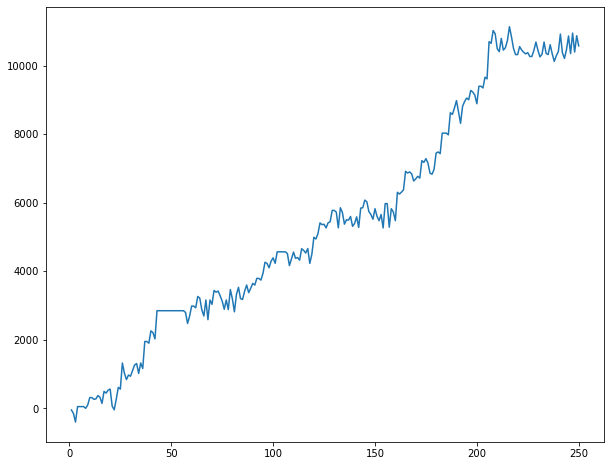

In [15]:
# backtesting m98strat (this is for stock 98 only)
from m98_demo import getMyPosition as getPosition

# Output
(meanpl, ret, sharpe, dvol) = calcPL(prcAll)
print ("=====")
print ("mean(PL): %.0lf" % meanpl)
print ("return: %.5lf" % ret)
print ("annSharpe(PL): %.2lf " % sharpe)
print ("totDvolume: %.0lf " % dvol)

| strategy                                               | parameters               | mean(PL) | return  | annSharp(PL) | totDvolume |
|--------------------------------------------------------|--------------------------|----------|---------|--------------|------------|
| Buy and hold (do not sell at end of 250 days)          | all 100 stocks, 250 days |       58 | 0.00467 |         0.22 |    3132449 |
| Buy and hold (sell at end of 250 days)                 | all 100 stocks, 250 days |       40 | 0.00242 |         0.14 |    4080282 |
| Buy and hold only stocks that increase during 250 days |                 250 days |       88 | 0.04254 |         1.31 |     516498 |
| Same as above (selling at end)                         |                 250 days |       82 | 0.02517 |         1.23 |     813868 |

<!-- Using this to generate tables https://www.tablesgenerator.com/markdown_tables# -->